In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc2


## Loading

In [2]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

In [5]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True,
  },
  "handle_imbalance": None,
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot",
    "froze_ms_coefs_round": 50
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 64,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0000,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4
    },
    "fedmechw_new2": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "gamma": 0.0,
      "scale_factor": 4,
      "mm_thres": 200
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 300,
            "learning_rate": 0.001,
            "weight_decay": 0.0,
            "pred_round": 500,
            "pred_local_epochs": 3,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [6]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def vis_mm_sim(mm_coefs, metric = 'cos'):
    n_cols = 5
    n_rows = (mm_coefs.shape[0] - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(mm_coefs.shape[0]):
        
        X = mm_coefs[feature_idx]
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("Mechanism Similarity")
    plt.tight_layout()
    plt.show()

In [7]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'
dataset = 'mimiciii_los'

In [11]:
def plot_comp(results, x):
    y_rmse = [r['imp_result']['imp@rmse'] for r in results]
    y_ws = [r['imp_result']['imp@ws'] for r in results]
    y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results]

    fig, ax = plt.subplots(1, 3, figsize=(12, 3))

    for i in range(3):
        ax[i].set_xlabel('alpha')

    ax[0].plot(x, y_rmse)
    ax[0].set_ylabel('RMSE')
    ax[1].plot(x, y_ws)
    ax[1].set_ylabel('ws')
    ax[2].plot(x, y_sliced_ws)
    ax[2].set_ylabel('sliced_ws')

    # rmse = 0.17884472919516609
    # ws =  0.4496532470292862
    # sliced_ws = 0.09188334255186284
    # ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
    # ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
    # ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

    # ax[0].legend()
    # ax[1].legend()
    # ax[2].legend()
    plt.tight_layout()
    plt.show()

In [14]:
dataset = 'codrna'
x = [0.3, 0.5, 0.7, 0.9, 1.0]

# Tuning

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevenl1-600 {}
[5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
sample sizes:  [5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-16 15:51:59.087 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:51:59.088 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-16 15:53:01.046 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:53:01.047 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-16 15:54:10.137 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:54:10.137 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-16 15:54:17.032 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 139.65566210000543


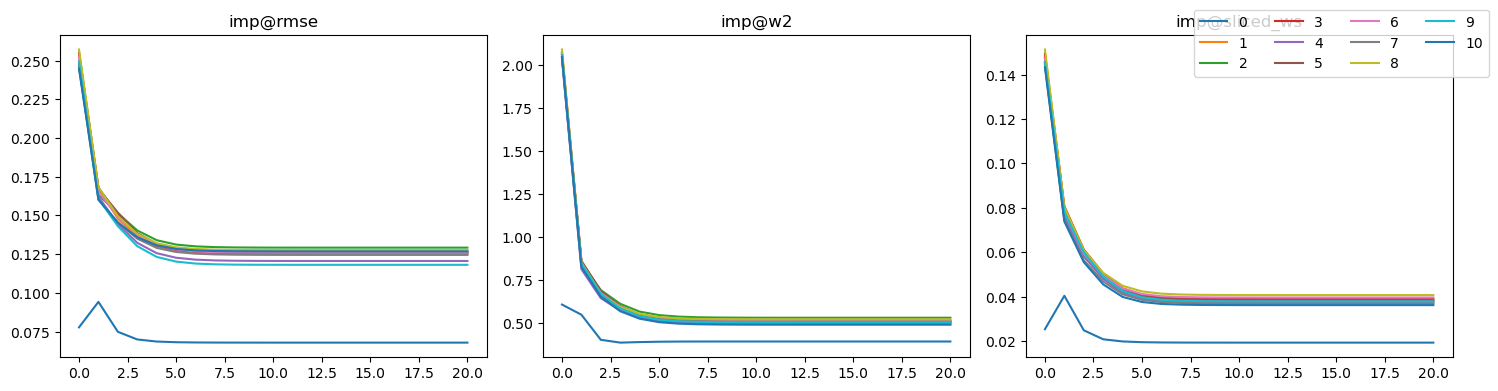

{'imp@rmse': 0.11984196359904263, 'imp@ws': 0.4968711969089411, 'imp@sliced_ws': 0.03643550959084375}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevenl1-600 {}
[5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
sample sizes:  [5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-16 15:54:19.256 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:54:19.256 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-16 15:55:21.025 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:55:21.026 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-16 15:56:30.132 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:56:30.133 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-16 15:56:37.050 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 139.48073740000837


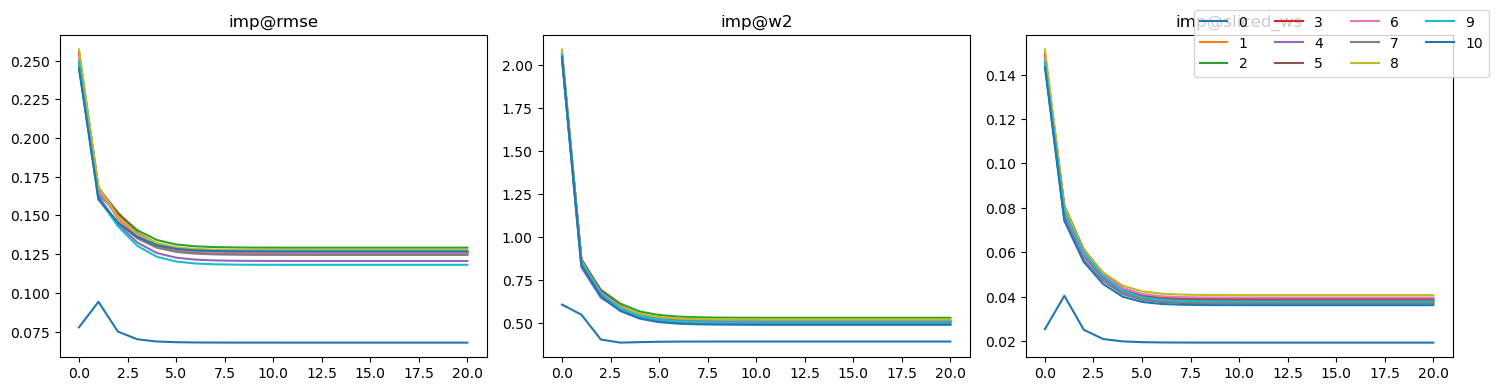

{'imp@rmse': 0.11982771253795964, 'imp@ws': 0.4966609187539268, 'imp@sliced_ws': 0.036400063728241575}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevenl1-600 {}
[5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
sample sizes:  [5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-16 15:56:39.293 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:56:39.293 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-16 15:57:40.898 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:57:40.899 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-16 15:58:50.230 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:58:50.230 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-16 15:58:57.127 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 139.52803769998718


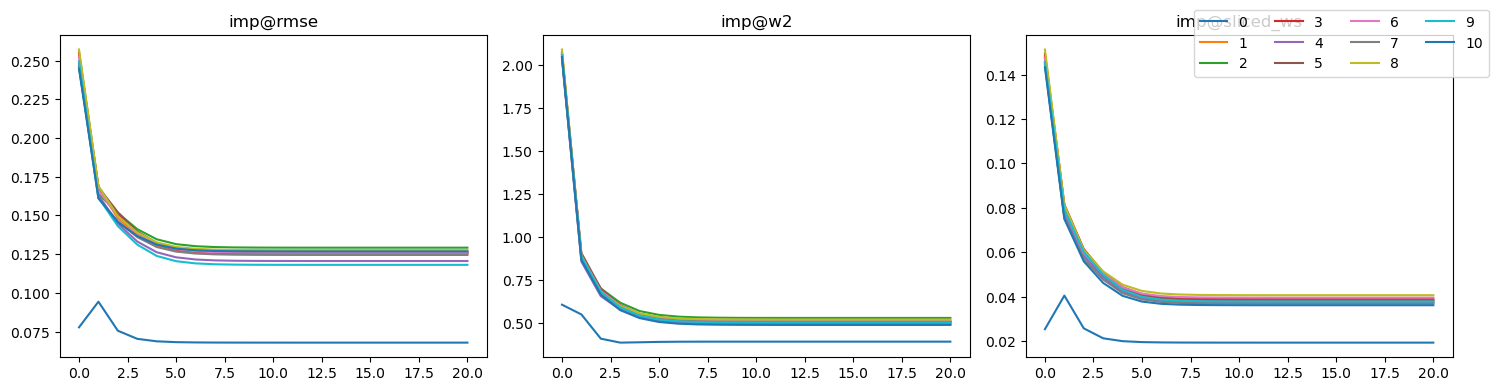

{'imp@rmse': 0.11981555481964047, 'imp@ws': 0.4965288527705455, 'imp@sliced_ws': 0.03638294089154975}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevenl1-600 {}
[5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
sample sizes:  [5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-16 15:58:59.363 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 15:58:59.363 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-16 16:00:01.499 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 16:00:01.500 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-16 16:01:10.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 16:01:10.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-16 16:01:17.463 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 139.78923890000442


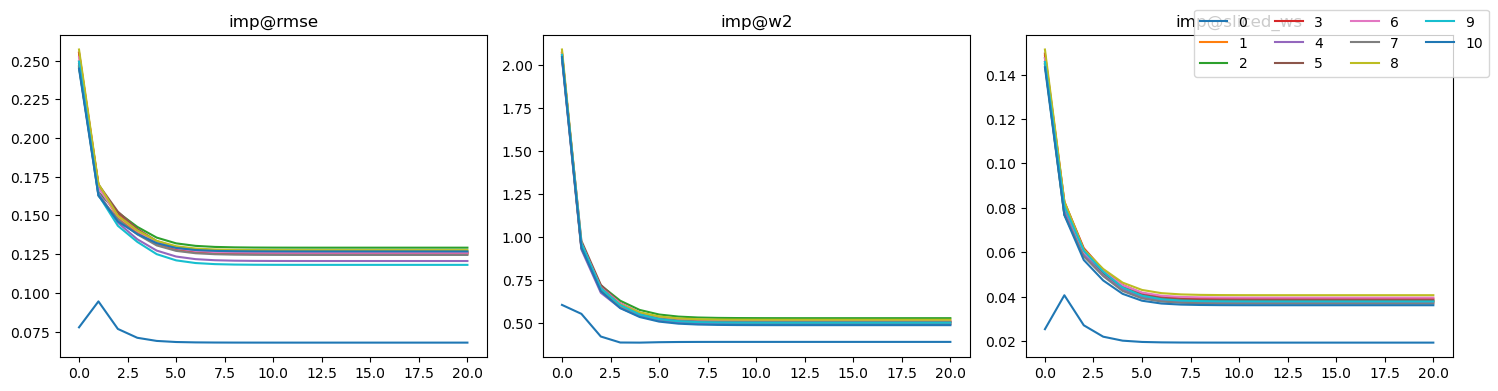

{'imp@rmse': 0.11981361757959959, 'imp@ws': 0.496500487819255, 'imp@sliced_ws': 0.03637811678998852}
(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-unevenl1-600 {}
[5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
sample sizes:  [5854, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-16 16:01:19.706 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 16:01:19.707 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-16 16:02:22.092 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 16:02:22.093 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-16 16:03:31.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-16 16:03:31.728 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-16 16:03:38.663 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 140.65181420001318


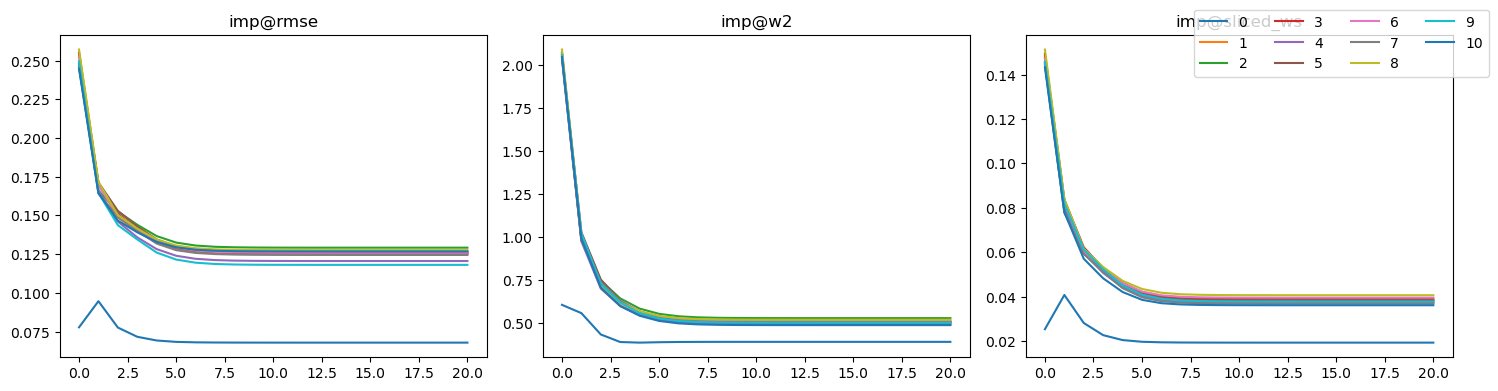

{'imp@rmse': 0.11981401059853455, 'imp@ws': 0.49650057502872247, 'imp@sliced_ws': 0.03637761191527361}


In [18]:
dataset = 'codon'
results_compl_alpha = []
for alpha in x:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-unevenl1-600'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())


# vis

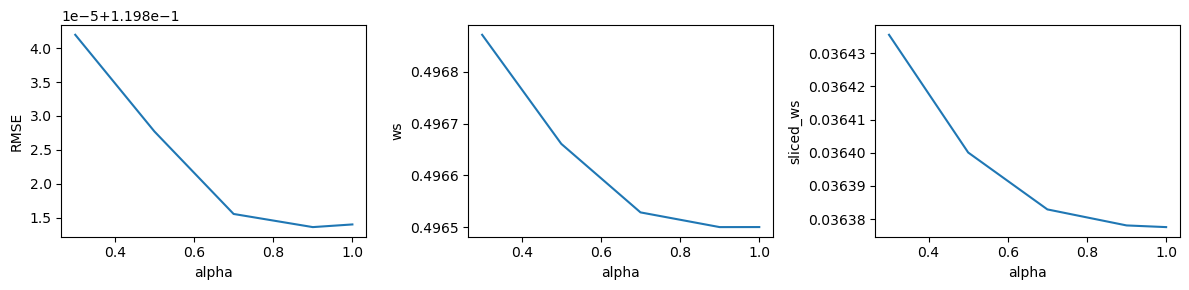

In [19]:
plot_comp(results_compl_alpha, x)

# Subcase1 -  1 vs N Uneven Split LR

(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 15:17:10.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:17:10.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 15:23:17.211 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:23:17.212 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 15:30:01.895 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:30:01.896 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 15:30:41.809 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 814.5075026999693


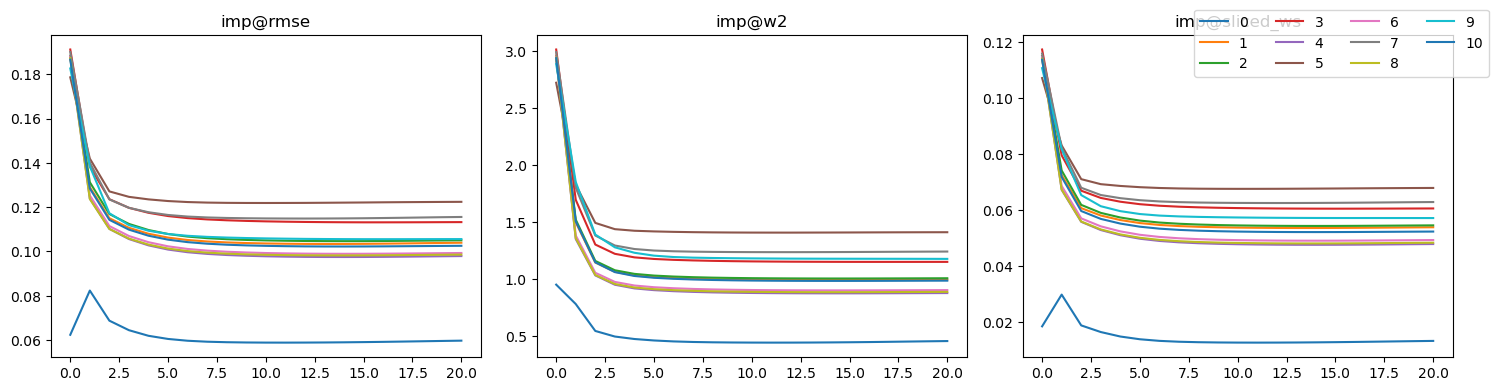

{'imp@rmse': 0.10201185967749447, 'imp@ws': 1.0098554599372929, 'imp@sliced_ws': 0.05154450103257548}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 15:30:45.970 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:30:45.971 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 15:36:50.277 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:36:50.278 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 15:43:35.020 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:43:35.021 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 15:44:15.500 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 812.9574855999672


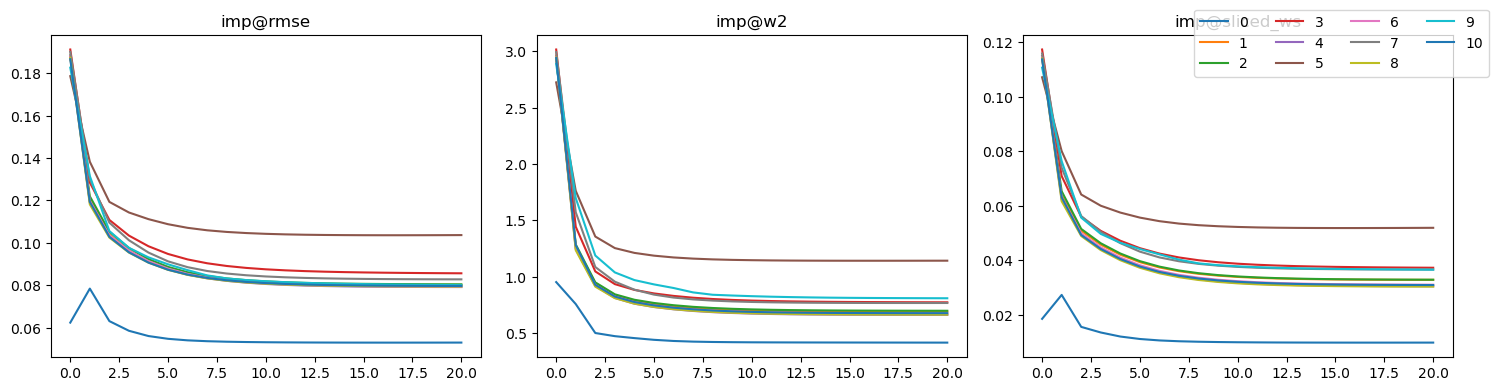

{'imp@rmse': 0.08033223401231404, 'imp@ws': 0.7264605032374644, 'imp@sliced_ws': 0.0327698849927232}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 15:44:19.727 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:44:19.727 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 15:50:24.505 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:50:24.507 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 15:57:12.596 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:57:12.598 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 15:57:51.856 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 815.6037547999877


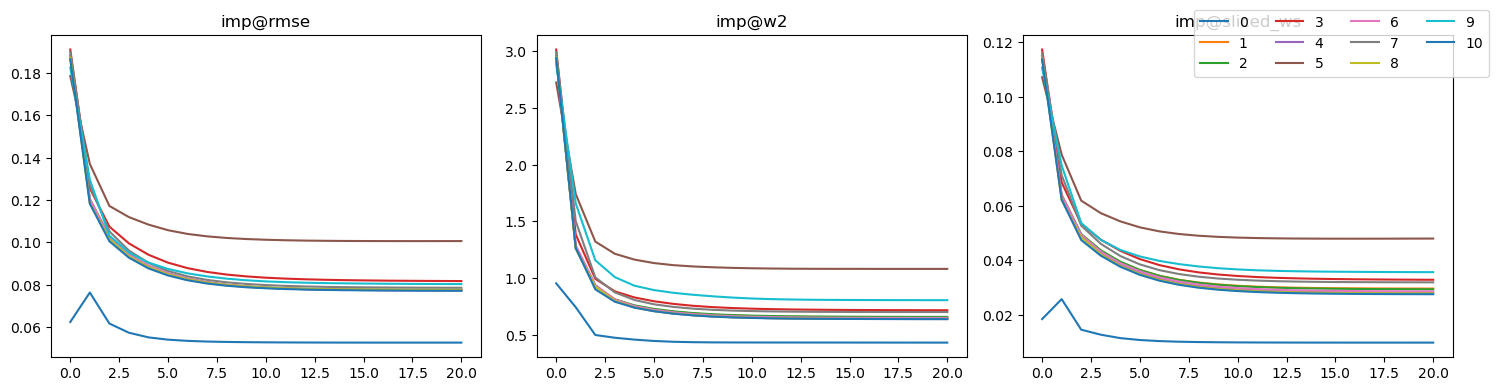

{'imp@rmse': 0.07803636403495971, 'imp@ws': 0.6926942254202035, 'imp@sliced_ws': 0.029993558972708924}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 15:57:55.632 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 15:57:55.633 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 16:03:49.500 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:03:49.501 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 16:10:22.050 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:10:22.051 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 16:11:01.338 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 788.8277062000125


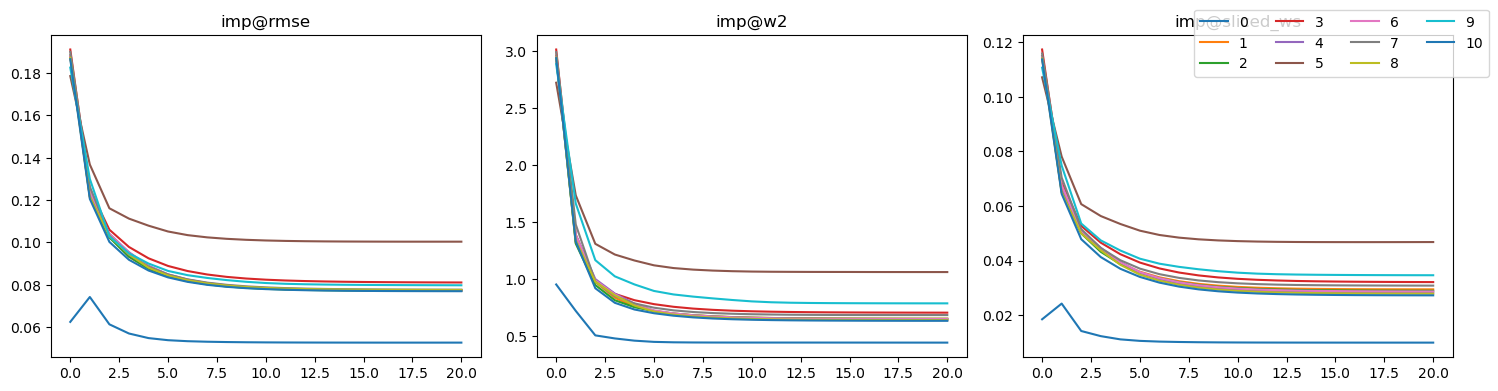

{'imp@rmse': 0.07770955837163679, 'imp@ws': 0.6876093187674512, 'imp@sliced_ws': 0.029511157838285198}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirl1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [3600, 1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197]
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 16:11:04.914 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:11:04.914 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 16:16:58.908 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:16:58.908 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 16:23:46.090 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:23:46.091 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 16:24:27.198 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 805.2859140000073


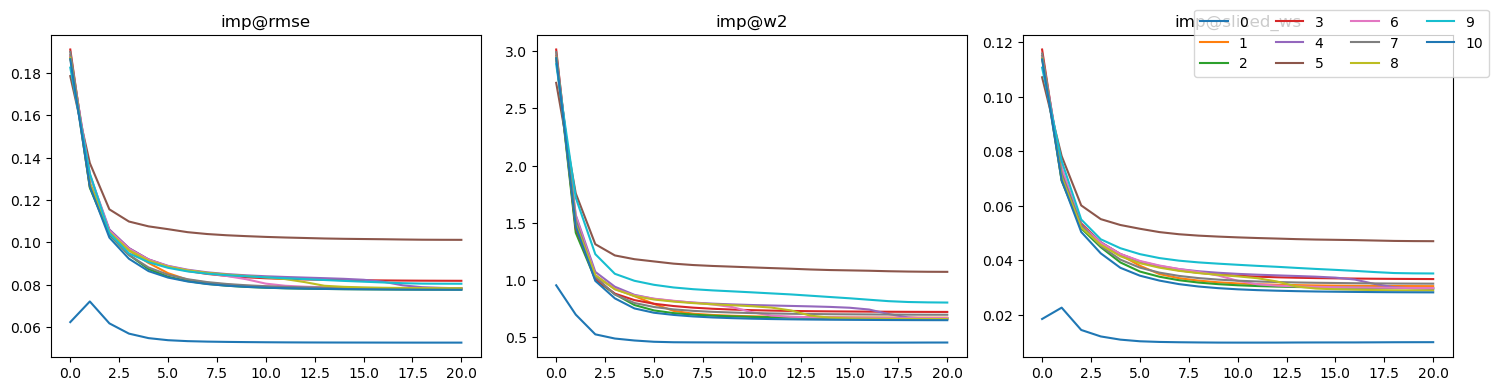

{'imp@rmse': 0.07862535336106047, 'imp@ws': 0.7057867903814591, 'imp@sliced_ws': 0.030494770361702925}


In [16]:
results_compl_alpha = []

for alpha in [0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
    config2['data_partition']['strategy'] = 'sample-unevendirl1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

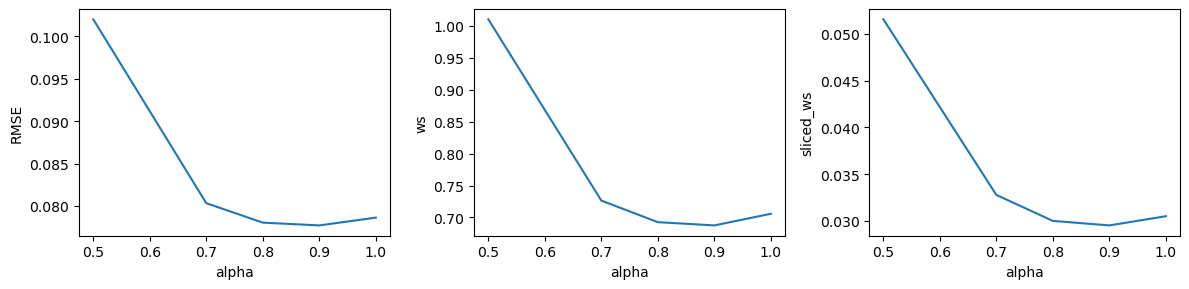

In [17]:
x = [0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.17884472919516609
# ws =  0.4496532470292862
# sliced_ws = 0.09188334255186284
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# Subcase 2 - 1 vs N Uevenly Split RL

(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-09 16:24:31.746 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:24:31.747 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 16:30:38.542 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:30:38.543 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 16:37:30.517 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:37:30.519 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 16:38:11.987 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 823.7704789999989


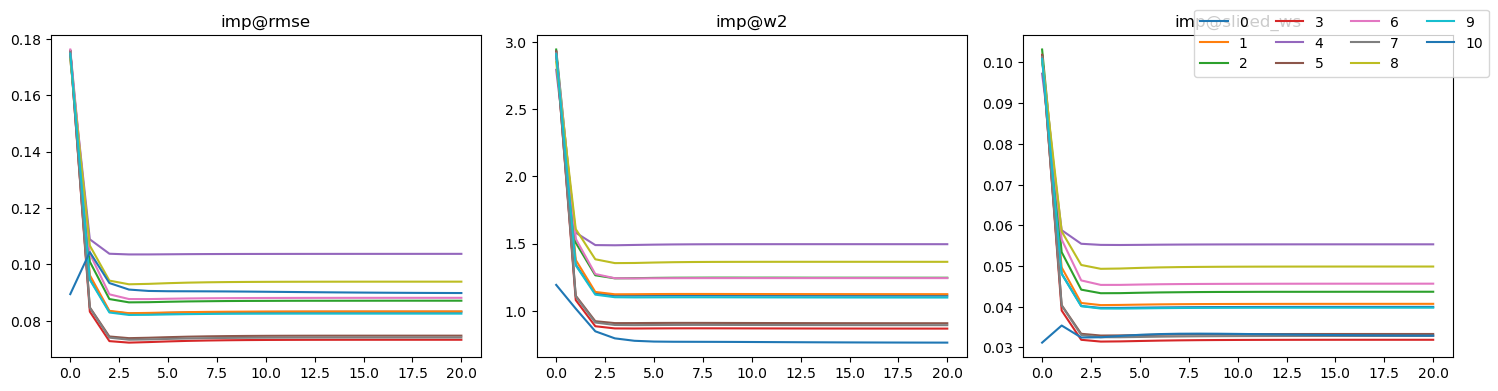

{'imp@rmse': 0.08494185396405829, 'imp@ws': 1.1007443923446076, 'imp@sliced_ws': 0.04053846224278994}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-09 16:38:16.103 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:38:16.104 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 16:44:29.730 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:44:29.731 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 16:51:23.626 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:51:23.627 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 16:52:04.706 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 831.9740546999965


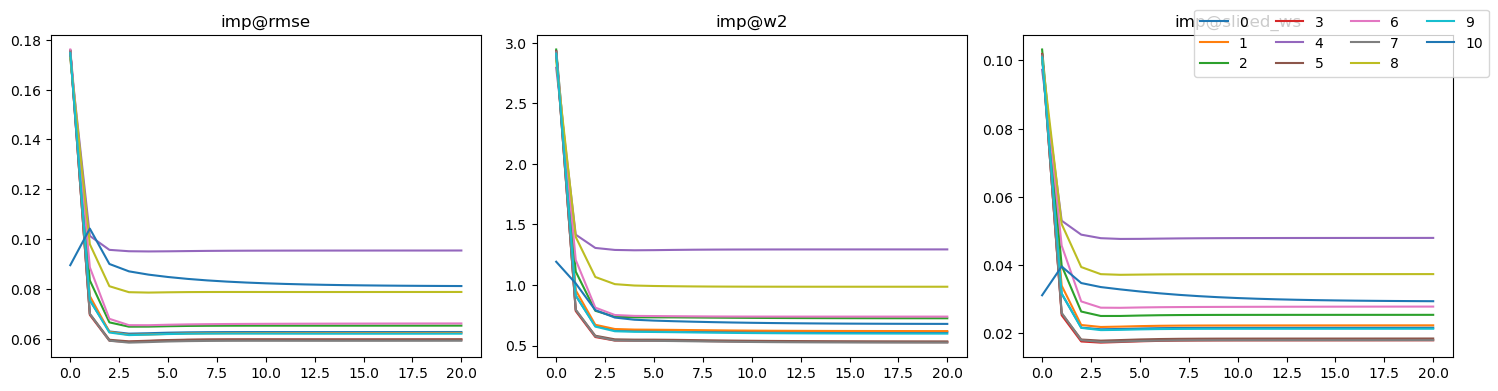

{'imp@rmse': 0.06835401549569328, 'imp@ws': 0.7125451400334506, 'imp@sliced_ws': 0.026196469688258246}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-09 16:52:08.869 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:52:08.869 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 16:58:20.947 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 16:58:20.948 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 17:05:12.703 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:05:12.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 17:05:55.155 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 829.7633606000454


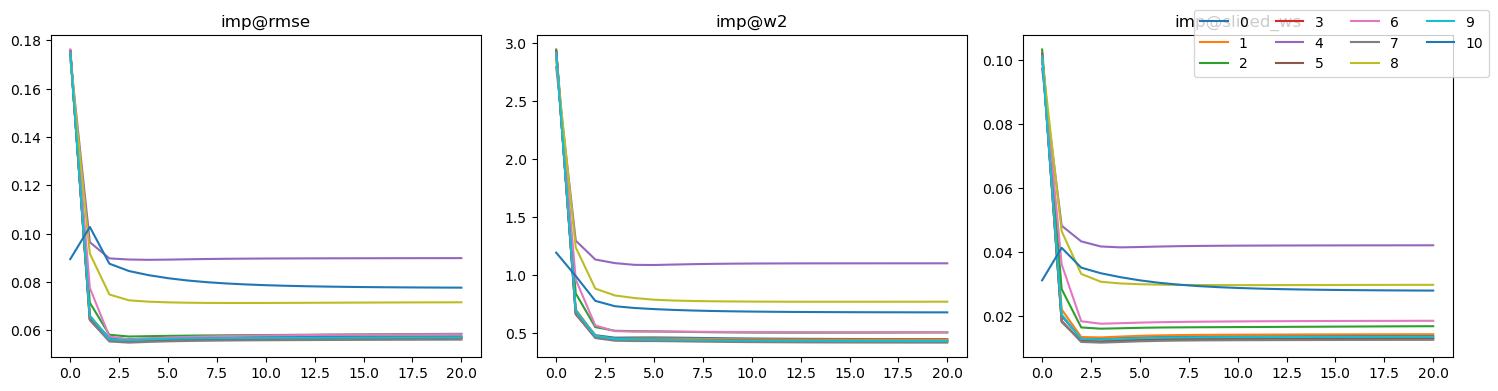

{'imp@rmse': 0.06342359088341844, 'imp@ws': 0.558291550391188, 'imp@sliced_ws': 0.019616618419548214}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-09 17:06:00.652 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:06:00.653 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 17:12:15.052 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:12:15.053 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 17:19:14.455 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:19:14.455 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 17:19:56.888 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 840.1641783000086


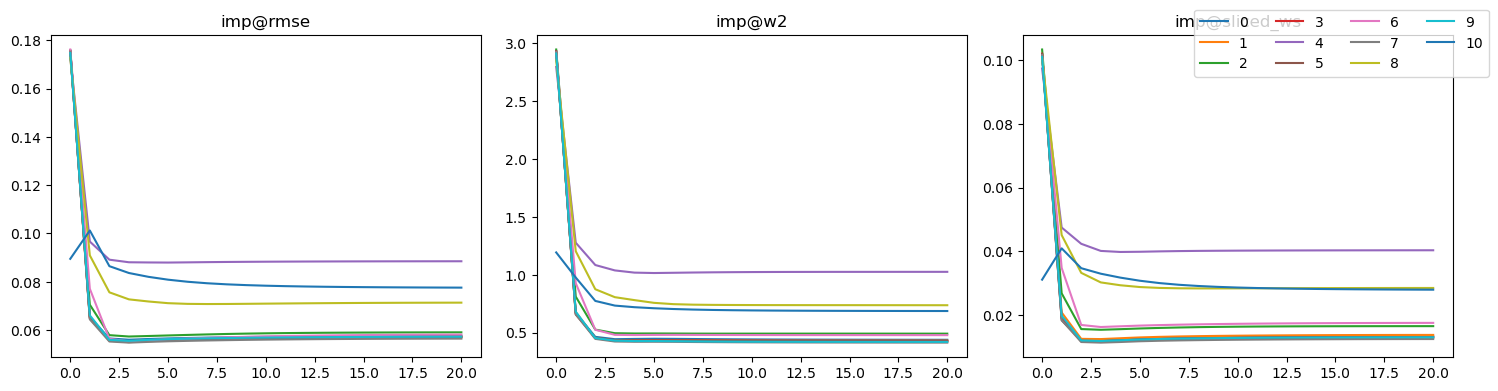

{'imp@rmse': 0.06337840282213804, 'imp@ws': 0.5426588879872832, 'imp@sliced_ws': 0.01914793332630239}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-09 17:20:01.313 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:20:01.314 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 17:26:15.503 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:26:15.504 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 17:33:11.635 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:33:11.636 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 17:33:53.867 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 836.1154455000069


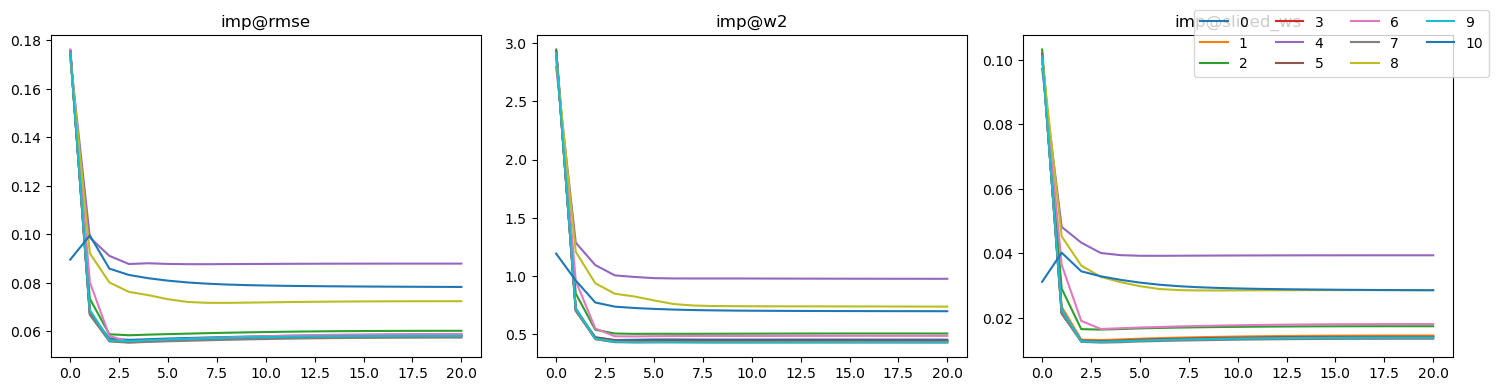

{'imp@rmse': 0.06410511175557317, 'imp@ws': 0.5501977096781092, 'imp@sliced_ws': 0.019683676612562796}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-unevendirr1 {}
2363 [1477.39180637  935.67709159  403.01557139 3414.31623098   62.3018653
 3269.6859934   229.36836761 3293.83105111  117.97918393 1196.43283833]
sample sizes:  [1478, 936, 404, 3415, 63, 3270, 230, 3294, 118, 1197, 3600]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']


2023-11-09 17:33:58.283 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:33:58.284 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 17:40:09.212 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:40:09.213 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 17:47:00.918 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:47:00.918 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 17:47:42.224 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 827.5769336000085


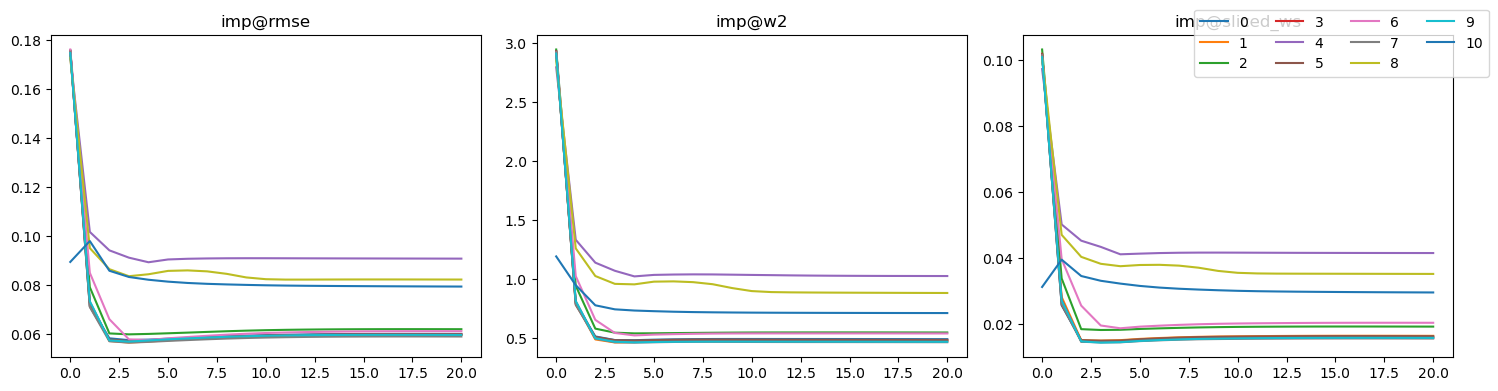

{'imp@rmse': 0.0667839158382875, 'imp@ws': 0.5983009550185965, 'imp@sliced_ws': 0.02195986422514663}


In [18]:
results_compl_alpha = []

for alpha in [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 11
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
    config2['data_partition']['strategy'] = 'sample-unevendirr1'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

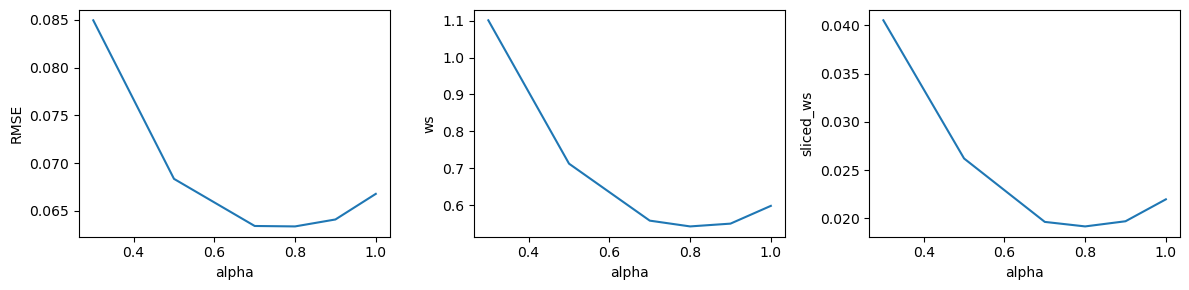

In [19]:
x = [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.17884472919516609
# ws =  0.4496532470292862
# sliced_ws = 0.09188334255186284
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# Subcase2 - 2 clusters

(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 4317, 302, 411, 1084, 2444, 4759]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 17:47:46.428 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:47:46.429 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 17:51:56.013 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:51:56.014 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 17:56:34.027 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:56:34.028 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 17:57:01.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 558.8528677999857


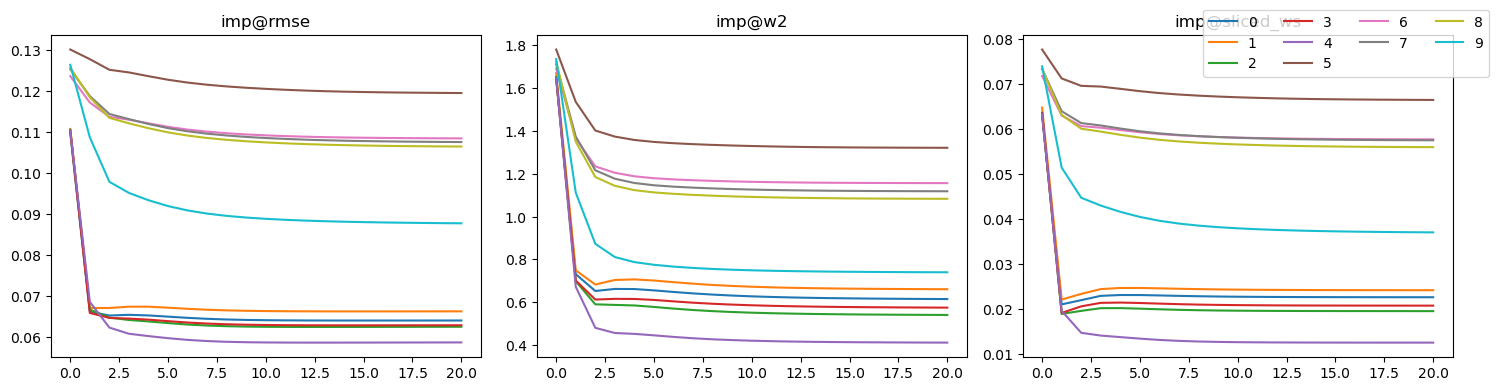

{'imp@rmse': 0.08439061369193705, 'imp@ws': 0.82307609345404, 'imp@sliced_ws': 0.03742832170935275}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 4317, 302, 411, 1084, 2444, 4759]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 17:57:05.670 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 17:57:05.671 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 18:01:17.311 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:01:17.312 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 18:05:56.503 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:05:56.504 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 18:06:24.948 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 562.3440241000499


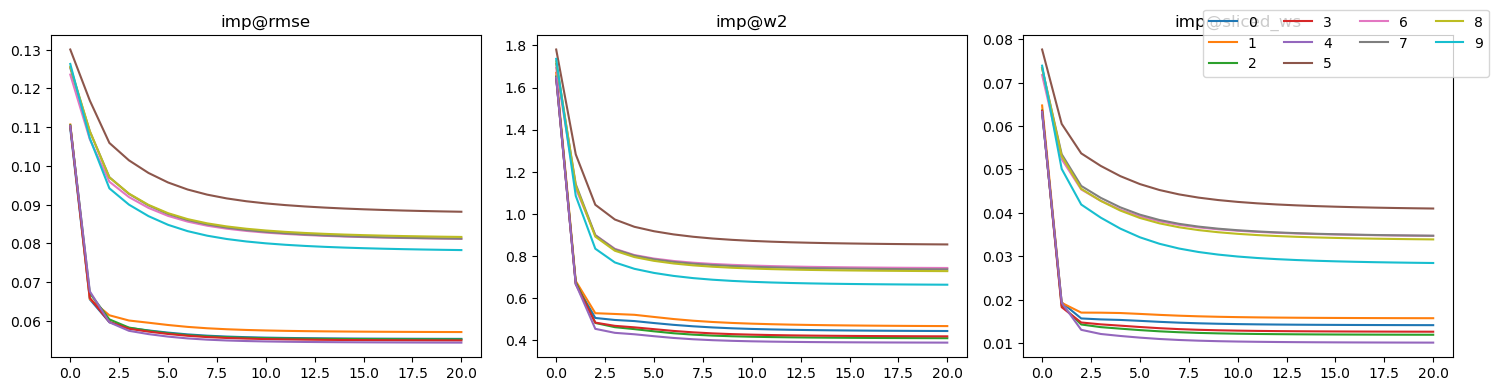

{'imp@rmse': 0.06880624626812609, 'imp@ws': 0.5841594049530756, 'imp@sliced_ws': 0.02378316685511326}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 4317, 302, 411, 1084, 2444, 4759]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 18:06:28.731 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:06:28.731 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 18:10:39.259 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:10:39.260 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 18:15:19.557 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:15:19.557 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 18:15:47.352 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 561.6956284999615


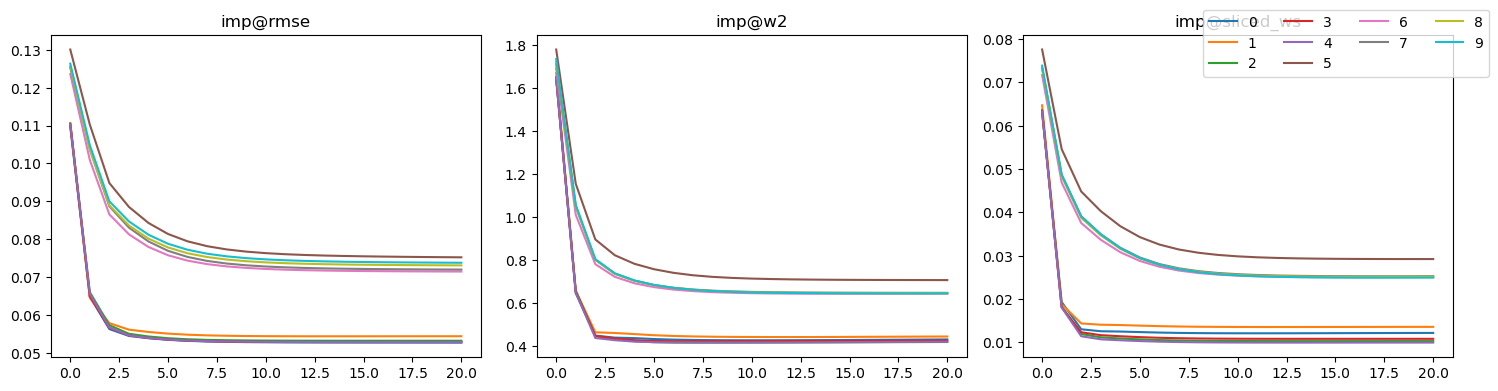

{'imp@rmse': 0.06316443024014692, 'imp@ws': 0.5411229140004703, 'imp@sliced_ws': 0.018593661250000143}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 4317, 302, 411, 1084, 2444, 4759]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 18:15:51.524 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:15:51.525 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 18:20:04.621 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:20:04.622 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 18:24:46.337 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:24:46.338 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 18:25:14.936 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 567.0090770000243


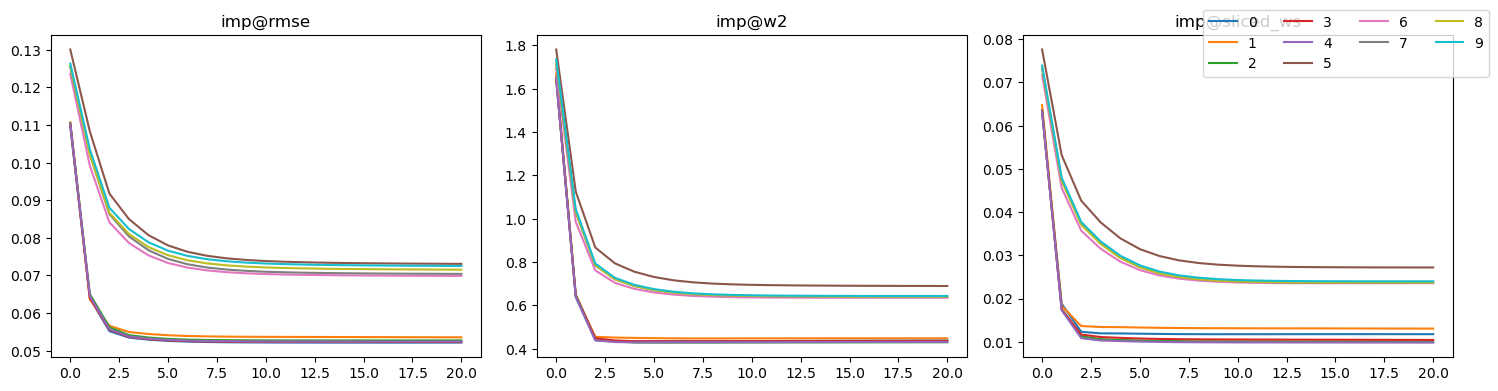

{'imp@rmse': 0.06208594616563743, 'imp@ws': 0.5427187174129228, 'imp@sliced_ws': 0.01771773209262185}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 4317, 302, 411, 1084, 2444, 4759]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 18:25:18.657 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:25:18.657 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 18:29:29.968 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:29:29.969 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 18:34:11.439 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:34:11.440 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 18:34:39.735 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 564.1495629000128


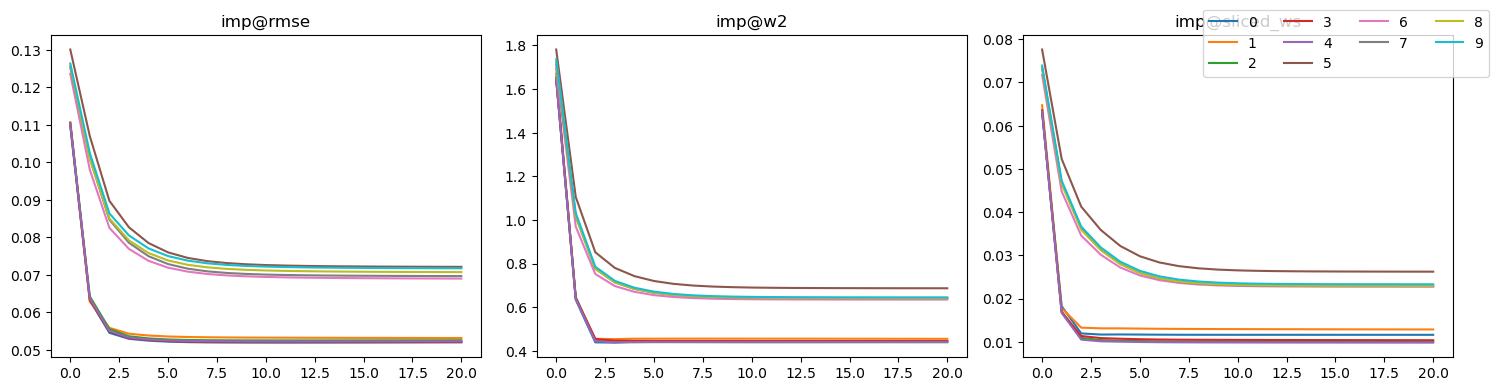

{'imp@rmse': 0.061517674425878216, 'imp@ws': 0.5472701052211272, 'imp@sliced_ws': 0.01726398381408534}
(20000, 51)
(18000, 51) (2000, 51)
(18000, 51)
sample-uneven10 {}
sample sizes:  [389, 282, 2517, 1495, 4317, 302, 411, 1084, 2444, 4759]
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']


2023-11-09 18:34:43.533 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:34:43.534 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 1
2023-11-09 18:39:05.602 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:39:05.603 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 10
2023-11-09 18:43:59.606 | INFO     | src.fed_imp.sub_modules.server.base_server:run:151 - ==================================================
2023-11-09 18:43:59.607 | INFO     | src.fed_imp.sub_modules.server.base_server:run:152 - Imputation Round 20
2023-11-09 18:44:28.691 | INFO     | src.fed_imp.sub_modules.server.base_server:run:181 - FL finished in 588.3322042999789


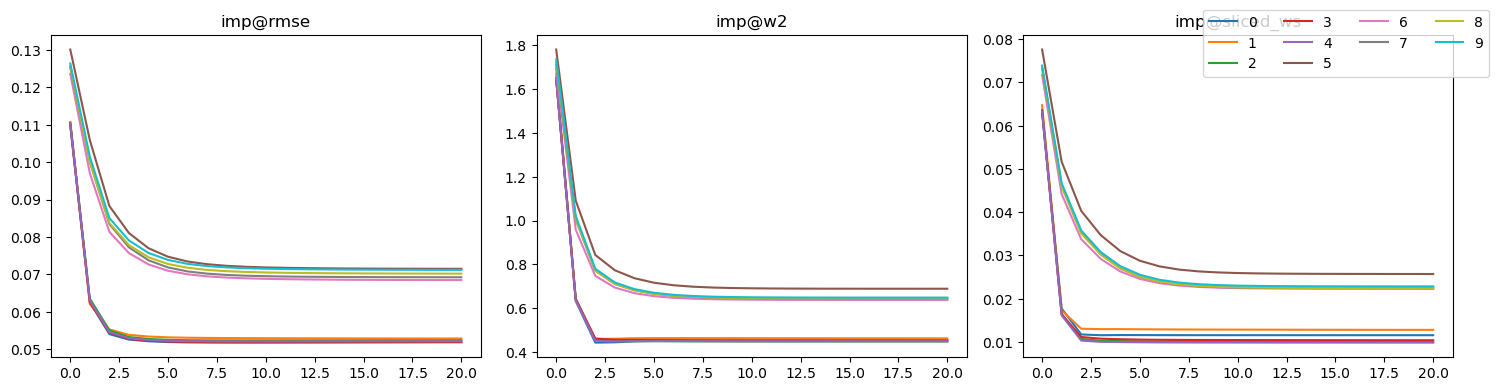

{'imp@rmse': 0.06119311628276728, 'imp@ws': 0.5526389465566837, 'imp@sliced_ws': 0.01700930682597235}


In [20]:
results_compl_alpha = []
for alpha in [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
    config2 = experiment_config_template.copy()
    config2['data']['dataset_name'] = dataset
    config2['num_clients'] = 10
    config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
    config2['missing_simulate']['mf_strategy'] = 'all'
    config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.5'
    config2['data_partition']['strategy'] = 'sample-uneven10'

    config2['agg_strategy_imp']['strategy'] = 'fedmechw_new'
    config2["algo_params"]["fedmechw_new"] = {
            "alpha": alpha,
            "gamma": 0.05,
            "client_thres": 1.0,
            "scale_factor": 4
        }
    config2['server_type'] = 'fedavg_pytorch'
    config2['prediction'] = False
    config2['save_state'] = True
    config2['track'] = True

    clients, test_data, new_seed = simulate_scenario(config2)
    server, ret = run_simulation(config2, clients, test_data, new_seed)
    results_compl_alpha.append(ret.copy())

# pred_ret = NN_evaluation(
#     rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
# )

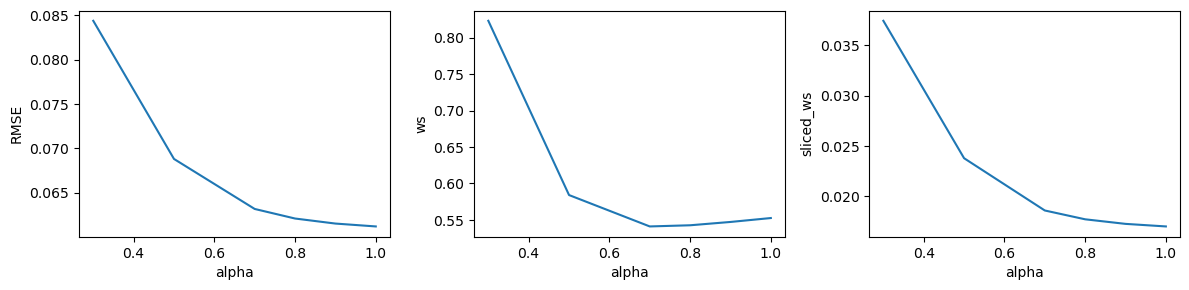

In [22]:
x = [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
y_rmse = [r['imp_result']['imp@rmse'] for r in results_compl_alpha]
y_ws = [r['imp_result']['imp@ws'] for r in results_compl_alpha]
y_sliced_ws = [r['imp_result']['imp@sliced_ws'] for r in results_compl_alpha]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
    ax[i].set_xlabel('alpha')

ax[0].plot(x, y_rmse)
ax[0].set_ylabel('RMSE')
ax[1].plot(x, y_ws)
ax[1].set_ylabel('ws')
ax[2].plot(x, y_sliced_ws)
ax[2].set_ylabel('sliced_ws')

# rmse = 0.31724148632788224
# ws = 1.0327202461435718
# sliced_ws = 0.1650482253637849
# ax[0].plot(x, [rmse] * len(x), '--', label = 'simpleavg')
# ax[1].plot(x, [ws] * len(x), '--', label = 'simpleavg')
# ax[2].plot(x, [sliced_ws] * len(x), '--', label = 'simpleavg')

# ax[0].legend()
# ax[1].legend()
# ax[2].legend()
plt.tight_layout()
plt.show()

# end